In [1]:
import math
import re
import numpy as np
import pandas as pd

In [4]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('omw-1.4')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/theodoremui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/theodoremui/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/theodoremui/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
import spacy
nlp = spacy.load("en_core_web_lg")

In [6]:
import os
import boto3
import botocore
import pyarrow as pa
import pyarrow.parquet as pq

In [7]:
%pwd

'/Users/theodoremui/Library/CloudStorage/OneDrive-Personal/dev/diversity-colleges/notebooks'

In [8]:
%cd ..

/Users/theodoremui/Library/CloudStorage/OneDrive-Personal/dev/diversity-colleges


In [9]:
import sys
sys.path.append('src')
import ouraws

In [49]:
S3_BUCKET="collegier"
OUTPUT_DIR="data"
SCHOOL="wellesley"
SUBJECT="opinions"
START_YEAR=2013
FINAL_YEAR=2022

In [50]:
def getCovDispersion(wv):
    N = len(wv)
    cov = np.cov(wv)
    return (N, 
            np.trace(cov)/N, 
            np.linalg.norm(cov, ord=1)/N, 
            np.linalg.norm(cov, ord=2)/N, 
            np.linalg.norm(cov, ord=np.inf)/N, 
            )

def cosine_distance(v1, v2):
    """Calculate the cosine distance between two numpy arrays.
    
    Parameters:
    a (numpy array): First input array.
    b (numpy array): Second input array.
    
    Returns:
    float: Cosine distance between a and b.
    """
    a = np.array(v1, dtype=np.float64)
    b = np.array(v2, dtype=np.float64)
    # Calculate dot product and magnitudes of the input arrays
    dot   = np.dot(a, b)
    a_mag = np.linalg.norm(a)
    b_mag = np.linalg.norm(b)
    
    if np.isclose(a_mag, 0, rtol=1e-9, atol=1e-12):
        print(f"a_mag is very small: {a_mag}")
    if np.isclose(b_mag, 0, rtol=1e-9, atol=1e-12):
        print(f"b_mag is very small: {b_mag}")
    
    # Calculate and return the cosine distance
    return 1.0 - (dot / (a_mag * b_mag))

def getPairwiseDispersion(wv, measure):
    if len(wv) <= 1: return 0.0
    distance = 0.0
    vec = wv[0]
    for v in wv[1:]:
        distance += measure(vec, v)
        # print(f"\tcos_distance: {measure(vec, v)}")
    return distance + getPairwiseDispersion(wv[1:], measure)

def getNormalizedPairwiseDispersion(wv, measure):
    '''Normalize the dispersion by (N-Choose-2) number of pairs'''
    N = len(wv)
    return getPairwiseDispersion(wv, measure) / (N * (N-1)/2.)

In [51]:
diversity_words = [
    'diversity', 
    'equity',
    'inclusion',
    'inclusive',
    'inclusivity',
    'equality', 
    'equal opportunity',
    'social justice',
    'racial justice', 
    'multi-cultural', 
    'multicultural',
    'intercultural',
    'intersectional',
    'intersectionality',
    'anti-discrimination'
]

In [52]:
len(diversity_words)

15

In [53]:
[(w) for w in diversity_words]

['diversity',
 'equity',
 'inclusion',
 'inclusive',
 'inclusivity',
 'equality',
 'equal opportunity',
 'social justice',
 'racial justice',
 'multi-cultural',
 'multicultural',
 'intercultural',
 'intersectional',
 'intersectionality',
 'anti-discrimination']

In [54]:
diversity_lemmas = [lemmatizer.lemmatize(w) for w in diversity_words]
diversity_lemmas

['diversity',
 'equity',
 'inclusion',
 'inclusive',
 'inclusivity',
 'equality',
 'equal opportunity',
 'social justice',
 'racial justice',
 'multi-cultural',
 'multicultural',
 'intercultural',
 'intersectional',
 'intersectionality',
 'anti-discrimination']

In [55]:
diversity_pattern = "|".join(diversity_lemmas)

In [56]:
diversity_pattern

'diversity|equity|inclusion|inclusive|inclusivity|equality|equal opportunity|social justice|racial justice|multi-cultural|multicultural|intercultural|intersectional|intersectionality|anti-discrimination'

In [57]:
text = "This is a multicultural organization that advocates for diversity and racial justice."
len(re.findall(diversity_pattern, text))

3

In [58]:
english_stopwords = stopwords.words('english')
def prepText(text_series):
    text_series = text_series.apply(
        lambda x: " ".join(lemmatizer.lemmatize(w.lower()) for w in x.split()
                           if w not in english_stopwords))
    text_series = text_series.apply(lambda x: x if len(x) > 100 else None)
    text_series = text_series.dropna()
    total_diversity_words = sum([len(re.findall(diversity_pattern, text))
                                for text in text_series])
    return text_series, total_diversity_words

In [59]:
%pwd

'/Users/theodoremui/Library/CloudStorage/OneDrive-Personal/dev/diversity-colleges'

In [60]:
S3OBJECT_KEY = f"{OUTPUT_DIR}/{SCHOOL}-{SUBJECT}-SNAPSHOT.parquet"
df = ouraws.getFromS3(S3OBJECT_KEY)

In [61]:
df.shape

(667, 6)

In [62]:
df.columns

Index(['title', 'url', 'body', 'year', 'month', 'day'], dtype='object')

In [63]:
df["year"].unique()

array([2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013])

In [64]:
df.loc[(df.year==2011) & (df.month==5)]

,title,url,body,year,month,day


In [66]:
results = []
for year in range(START_YEAR, FINAL_YEAR+1):
    year_df = df[df.year==year]
    
    clean_df, num_diversity_words = prepText(year_df.body)
    wv = [nlp(s) for s in clean_df]
    
    docmatrix = np.array([v.vector for v in wv])
    
    pairwise = getNormalizedPairwiseDispersion(docmatrix, cosine_distance)
    cov = getCovDispersion(docmatrix)
    
    print(f"{year}, {cov[0]}, {cov[1]}, {pairwise}")
    
    result = {'year':     year,
              'pairwise': pairwise,
              'size':     cov[0],
              'trace':    cov[1],
              'norm-1':   cov[2],
              'norm-2':   cov[3],
              'norm-inf': cov[4],
              'diversity-words': num_diversity_words,
              'mentions-norm'  : num_diversity_words/cov[0]
             }
    results.append(result)

2013, 36, 1.9586871258939489, 0.07835495298421051
2014, 120, 2.0309036977851975, 0.07791730021323649
2015, 92, 2.0776869782659166, 0.06253592078022636
2016, 82, 2.1215626366509532, 0.05702754362430434
2017, 76, 2.0748587424440714, 0.061142895122295586
2018, 70, 2.0442943576476136, 0.06537682945171214
2019, 67, 1.9906377315792252, 0.0643123863106481
2020, 42, 1.9460219562861778, 0.07629527834799223
2021, 41, 1.9700081842854171, 0.0813491063535226
2022, 40, 2.02221624098807, 0.07399564883604115


In [67]:
results_df = pd.DataFrame.from_records(results)
results_df.set_index('year')

,pairwise,size,trace,norm-1,norm-2,norm-inf,diversity-words,mentions-norm
year,,,,,,,,
2013,0.078355,36,1.958687,2.040618,1.811410,2.040618,19,0.527778
2014,0.077917,120,2.030904,2.188819,1.877284,2.188819,97,0.808333
2015,0.062536,92,2.077687,2.222771,1.950511,2.222771,84,0.913043
2016,0.057028,82,2.121563,2.258310,2.003363,2.258310,121,1.475610
2017,0.061143,76,2.074859,2.245895,1.950078,2.245895,59,0.776316
2018,0.065377,70,2.044294,2.125540,1.913498,2.125540,62,0.885714
2019,0.064312,67,1.990638,2.077657,1.865828,2.077657,34,0.507463
2020,0.076295,42,1.946022,2.023509,1.803899,2.023509,47,1.119048
2021,0.081349,41,1.970008,2.074583,1.812592,2.074583,49,1.195122


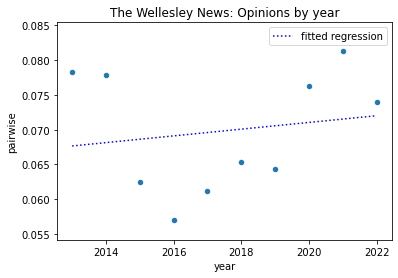

In [68]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

x = results_df['year']
y = results_df['pairwise']

slope, intercept, r_value, p_value, std_err = linregress(x, y)

results_df.plot(x="year", y="pairwise", kind="scatter")

plt.plot(x, intercept + slope*x, 'b:', label='fitted regression')

plt.title("The Wellesley News: Opinions by year")
plt.legend(loc='upper right')
plt.ylim(min(y)*0.95, max(y)*1.05)
plt.show()

mentions-norm slope:0.02329, int:0.80105, r:0.23870, p:0.50660, se:0.03350, x:range(0, 10)
pairwise slope:0.00048, int:0.06766, r:0.16909, p:0.64050, se:0.00100, x:range(0, 10)


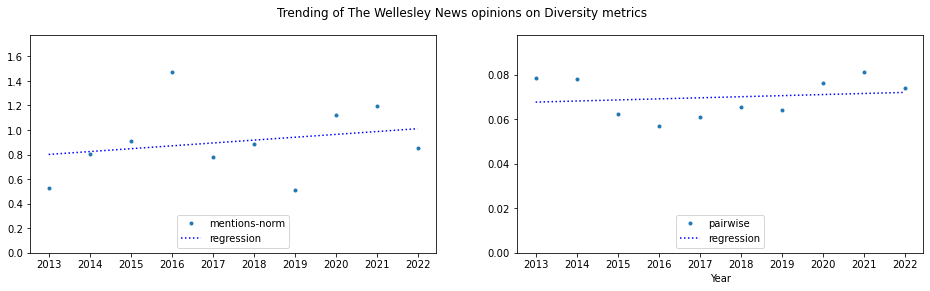

In [69]:
# Select the columns to plot
columns = ["mentions-norm", "pairwise"]

# Create a figure with subplots
fig, axs = plt.subplots(nrows=1, ncols=len(columns), sharex=True, figsize=(16,4))

# Loop through the columns and plot each one
for ax, column in zip(axs, columns):
    # Select the data for the current column
    x = range(len(results_df.index))
    y = results_df[column]
     
    # Calculate the linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    print("{} slope:{:.5f}, int:{:.5f}, r:{:.5f}, p:{:.5f}, se:{:.5f}, x:{}".format(
            column, slope, intercept, r_value, p_value, std_err, x))

    # Plot the data and the linear regression line
    results_df[column].plot(ax=ax, style=".", x=x, y=y, label=column)
    ax.plot(x, intercept + slope*x, 'b:', label='regression')
    ax.set_ylim(0, max(y)*1.2)
    
    # Add a legend
    ax.legend(loc='lower center')

    # Add x-label for the years
    ax.set_xticks(results_df.index)
    ax.set_xticklabels(results_df.year)
    
plt.xlabel("Year")
plt.suptitle("Trending of The Wellesley News opinions on Diversity metrics")
plt.show()